<a href="https://colab.research.google.com/github/AgustinGurvich/TMD/blob/main/TMD_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [1]:
install.packages("randomForest", dependencies = T)
library(randomForest)
install.packages("kernlab", dependencies = T)
library(kernlab)
library(MASS)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘ggplot2’


The following object is masked from ‘package:kernlab’:

    alpha


The following object is masked from ‘package:randomForest’:

    margin




Estimaciones de error

In [2]:
#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}

#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	
	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2
	m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C)
	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


Codigo para el wrapper greedy forward

In [3]:
#-------------------------------------------------------------------------------------
# AVISO: este codigo esta adaptado de un paquete mayor. 
# No es optimo y tiene cosas inutiles para nosotros. Es un ejemplo nada mas
#
#general forward greedy selection function
#input:
# x,y inputs and targets
# method is an external function that estimates classification error with a given model
# ... parameters for method
#output:
#ordered.names.list <- nombre de las variables ordenadas de la mas importante a la menos
#ordered.features.list <-numero de orden inicial de las variables, con el mismo orden
#importance <- importancia de cada variables en el mismo orden

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2] #Cantidad de variables (digamosle k)
	num.feat<-1 #Cantidad inicial de variables
	list.feat<-1:max.feat #Sequencia de 1 a k donde guardo las variables mas importantes

	#ranking inicial: elijo la variable con menor error de prediccion
  x.train<-matrix(0,dim(x)[1],1) #Columna de 0 de tamaño n 
	class.error<-double(max.feat) #Aca voy a guardar todos los errores
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train[,1]<-x[,i] #Lleno la variable donde guardo los datos de train con la columna de la variable que me importa
		class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) ) # Entreno un modelo y guardo el error
	}
	#guardo la variable con minimo error como primera. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error) #Aca quedan ordenadas por importancia
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1] #Aca quedan las que tengo que probar
	#armo un dataset con las variables que ya elegi, para ir agregando en cada paso.
	x.prev<-x.train[,1]<-x[,list.feat[1]] #En x.train pongo la variable importante como columna, y guardo esa columna como variable en x.prev

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
    #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat) #Voy sacando features
		#para cada variable que me queda, la agrego al dataset del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-cbind(x.prev,x[,keep.feat[i]]) #En x.prev estaban las variables que me servian, le agrego como columna la nueva variable 
			class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>1) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1
		x.prev<-x[,list.feat[1:num.feat]] #Como en list.feat estaban las que me servian, ordenadas, las guardo en x.prev
	}

	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",search.names,"\n")
	}

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}

Codigo para el wrapper greedy backward

In [4]:
backward.ranking <- function(x,y,method,... )
{

	max.feat<-dim(x)[2] #Cantidad de variables (digamosle k)
	list.feat<-1:max.feat #Sequencia de 1 a k donde guardo las variables mas importantes
	num.feat<-0 #Cantidad de variables que saque (ninguna)
	keep.feat <- 1:max.feat #Guardo las variables que me van quedando

	#ranking inicial: entreno un modelo completo y le mido el error
  x.train<-x #El primer entrenamiento se hace con todo el dataset
	previous.error <- do.call(method, c(list(as.matrix(x.train), y), list(...)) ) # Entreno un modelo completo y guardo el error

    class.error<-double(max.feat)
    for(i in 1:max.feat){
		x.train<-x[,-i] #En la primer iteracion saco una sola variable
		class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
        class.error[i] <- abs(class.error[i] - previous.error) #Diferencia con el error anterior
    }


	#Saco la variable que menos error me agrego (no era tan importante). Guardo una lista keep.feat con las que me quedan para seguir sacando.
	min.error.index <- which.min(class.error) #La que menor error deja es la menos importante (no afecto que la saque) 
    previous.error <- class.error[min.error.index] #El modelo adecuado es este
    list.feat[1]<-min.error.index #Aca quedan ordenadas por menor importancia
	keep.feat<-keep.feat[-min.error.index] #Aca quedan las que tengo que probar
	#Saco del dataset las variables que ya probe
    num.feat<-num.feat+1

    #loop principal. A cada paso saco variables, de a una, le mido el error y elimino la de minimo error. Hasta que me quede la mas importante.
	while(num.feat < max.feat -1 ){
    #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat) #Voy sacando features
		#para cada variable que me queda, la saco del dataset, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
			x.train<-x[,keep.feat[-i]] #Construyo el conjunto de train usando las feats que me interesan
			class.error[i] <- do.call(method, c(list(as.matrix(x.train), y), list(...)) )
			class.error[i] <- abs(class.error[i] - previous.error) #Diferencia con el error anterio
		}
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan, y actualizo el dataset de partida de la iteracion.
		min.error.index<-which.min(class.error)
		previous.error <- class.error[min.error.index]
		list.feat[num.feat+1]<-keep.feat[min.error.index]
		keep.feat<-keep.feat[-min.error.index]

		num.feat<-num.feat+1
	}

	list.feat[num.feat+1] <- keep.feat[1] #Me quedaba una feature sin probar
	list.feat <- rev(list.feat) #Las variables mas importantes quedaron al final de la lista
	search.names<-colnames(x)[list.feat]
	#le asigno a cada feature una importacia proporcional al orden en que lo seleccionamos
	imp<-(max.feat:1)/max.feat
	names(imp)<-search.names

 	return( list(ordered.names.list=search.names,ordered.features.list=list.feat,importance=imp) )

}

Codigo para el filter con test no-paramétrico

In [23]:
no.parametrico <- function(x,y){
  var.count <- dim(x)[2]
  stat <- c()
  for (i in 1:var.count){
    var<-x[,i]
    stat[i] <- kruskal.test(var,y)$statistic
  }
  ordered.vars <- order(stat, decreasing=T) 
  var.names<-colnames(x)[ordered.vars]
  imp<-(var.count:1)/var.count
	names(imp)<-var.names
  return( list(ordered.names.list=var.names,ordered.features.list=ordered.vars,importance=imp) )

}

Codigo para el RFE

In [6]:
rfe <- function(x,y,method,...){
  p <- dim(x)[2]
  F <- 1:p #Todas mis variables
  R <- c()
  for(i in 1:p){
    #Truco que me sirvio para entender que estoy haciendo al construir el dataset de entrenamiento:
    #F es una lista de indices (guarda todas las variables que voy a usar)
    #En lugar de hacer algun truco raro para llevar registro de que voy eliminando, reconstruyo el dataset de entrenamiento con los indices
    x.train <- as.matrix(x[,F]) #Tengo que pasarlo a matrix porque sino tengo problemas con las dimensiones
    values <- do.call(method, c(list(x.train, y), list(...)) ) 
    fIndex <- values$feats[1] #Obtengo la variable menos importante
    R[p-i+1] <- F[fIndex] #Agrego la variable menos importante
    F <- F[-fIndex] #Elimino la variable de mi lista de variables
  }
  var.names<-colnames(x)[R]
  imp<-(p:1)/p
	names(imp)<-var.names
  return( list(ordered.names.list=var.names,ordered.features.list=R,importance=imp) )

}

Aplicamos cada analisis

In [ ]:
#demo: aplicar el wrapper a los datos de iris
data(iris)

In [ ]:
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")
print(FORW.rf)
print(FORW.lda)

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
BACK.rf <-backward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
print(BACK.rf)
BACK.lda<-backward.ranking(iris[,-5],iris[,5],method="lda.est")
print(BACK.lda)

$ordered.names.list
[1] "Petal.Width"  "Sepal.Length" "Sepal.Width"  "Petal.Length"

$ordered.features.list
[1] 4 1 2 3

$importance
 Petal.Width Sepal.Length  Sepal.Width Petal.Length 
        1.00         0.75         0.50         0.25 

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
noP <- no.parametrico(iris[,-5],iris[,5])
print(noP)

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [ ]:
RFE.rf <- rfe(iris[,-5],iris[,5],method="imp.rf",tot.trees=100,equalize.classes=F)
print(RFE.rf)
RFE.linsvm <- rfe(iris[,-5],iris[,5],method="imp.linsvm")
print(RFE.linsvm)

$ordered.names.list
[1] "Petal.Width"  "Petal.Length" "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 4 3 1 2

$importance
 Petal.Width Petal.Length Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 

 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
 Setting default kernel parameters  
$ordered.names.list
[1] "Petal.Length" "Petal.Width"  "Sepal.Length" "Sepal.Width" 

$ordered.features.list
[1] 3 4 1 2

$importance
Petal.Length  Petal.Width Sepal.Length  Sepal.Width 
        1.00         0.75         0.50         0.25 



In [7]:
crea.ruido.unif<-function(n=100,d=2){
  x<-runif(2*n*d,min=-1)	#genero los datos
  dim(x)<-c(2*n,d)
  return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

Aplicamos los metodos de seleccion de variables sobre datosA

In [ ]:
#datosA
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

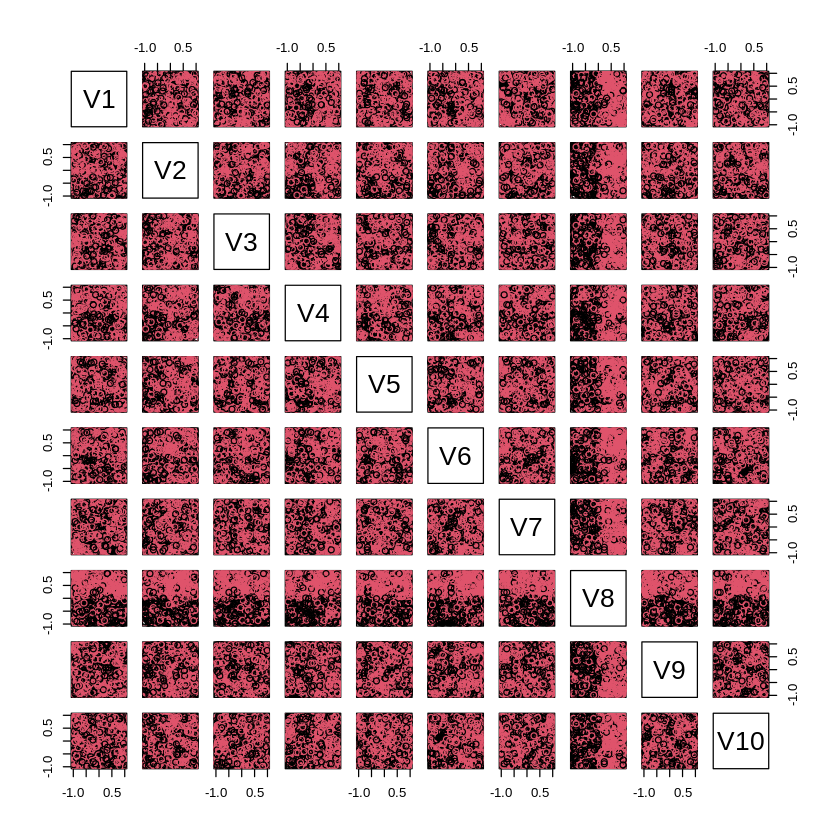

In [ ]:
plot(datosA[,-11],col=datosA[,11])

In [ ]:
print("Metodos de forward wrapper")
invisible(capture.output(datosA.FORW.svm<-forward.ranking(datosA[,-11],datosA[,11],method="svm.est")))
print("Resultado con FORW.svm")
print(datosA.FORW.svm$importance)
datosA.FORW.rf <-forward.ranking(datosA[,-11],datosA[,11],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con FORW.rf")
print(datosA.FORW.rf$importance)
datosA.FORW.lda<-forward.ranking(datosA[,-11],datosA[,11],method="lda.est")
print("Resultado con FORW.lda")
print(datosA.FORW.lda$importance)

print("Metodos de backward wrapper")
invisible(capture.output(datosA.BACK.svm<-backward.ranking(datosA[,-11],datosA[,11],method="svm.est")))
print("Resultado con BACK.svm")
print(datosA.FORW.svm$importance)
datosA.BACK.rf <-backward.ranking(datosA[,-11],datosA[,11],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con BACK.rf")
print(datosA.BACK.rf$importance)
datosA.BACK.lda<-backward.ranking(datosA[,-11],datosA[,11],method="lda.est")
print("Resultado con BACK.lda")
print(datosA.BACK.lda$importance)

print("Test no parametrico")
datosA.noP <- no.parametrico(datosA[,-11],datosA[,11])
print("Resultado con noP")
print(datosA.noP$importance)

print("Metodos de RFE")
datosA.RFE.rf <- rfe(datosA[,-11],datosA[,11],method="imp.rf",tot.trees=100,equalize.classes=F)
print("Resultado con RFE.rf")
print(datosA.RFE.rf$importance)
invisible(capture.output(datosA.RFE.linsvm <- rfe(datosA[,-11],datosA[,11],method="imp.linsvm")))
print("Resultado con RFE.linsvm")
print(datosA.RFE.linsvm$importance)

[1] "Metodos de forward wrapper"
[1] "Resultado con FORW.svm"
 V8  V3  V9  V7  V5 V10  V1  V2  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con FORW.rf"
 V8  V9  V3  V2  V5 V10  V1  V7  V6  V4 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con FORW.lda"
 V8  V5  V9  V3  V7  V1 V10  V2  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Metodos de backward wrapper"
[1] "Resultado con BACK.svm"
 V8  V3  V9  V7  V5 V10  V1  V2  V4  V6 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con BACK.rf"
 V8  V9 V10  V1  V7  V6  V3  V4  V5  V2 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Resultado con BACK.lda"
 V8  V9 V10  V7  V1  V2  V4  V5  V6  V3 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Test no parametrico"
[1] "Resultado con noP"
 V8  V6  V4  V2  V9  V1  V5  V3 V10  V7 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Metodos de RFE"
[1] "Resultado con RFE.rf"
 V8  V6  V4  V7  V9  V5  V3  V2 V10  V1 
1.0 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1 
[1] "Re

Todos los tests coinciden que la variable más importante es V8, lo cual tiene sentido pues determina el signo del 50% de los datos.

El test no parametrico y RFE ponen como segunda variable importante a V6, pero los otros metodos la colocan cerca del final. Si bien V6 determina el 20% de los datos, creo que se puede deber a la forma en la que se construyó el dataset. Probablemente la muestra que generé está distribuida de forma tal que V7 también determine una buena parte de los datos.

En los casos de los wrappers, al cambiar el método de estimación de error no parece cambiar significativamente el resultado final. Los puestos altos de los rankings son muy similares. En el caso de RFE, los 3 primeros puestos son idénticos en ambos casos.

El test no paramétrico parece ser el más poderoso de todos, pues acertó las 4 variables que utilizamos para manipular los datos.

Aplicamos los metodos de seleccion de variables sobre datosB

In [ ]:
#datosB
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

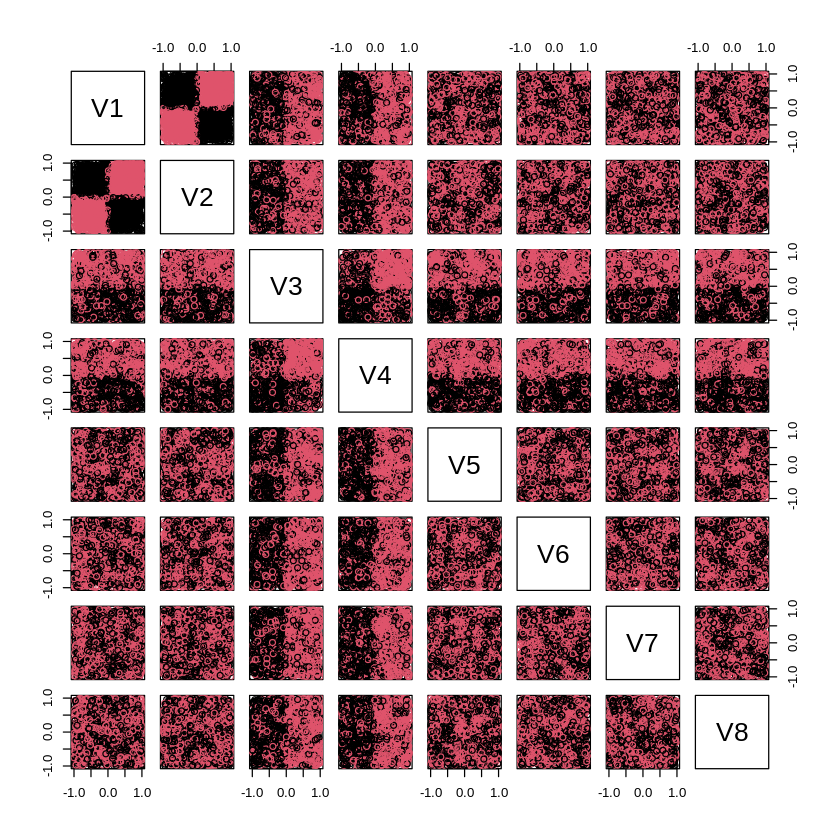

In [ ]:
plot(datosB[,-9],col=datosB[,9])

In [ ]:
print("Metodos de forward wrapper")
invisible(capture.output(datosB.FORW.svm<-forward.ranking(datosB[,-9],datosB[,9],method="svm.est")))
print("Resultado con FORW.svm")
print(datosB.FORW.svm$importance)
datosB.FORW.rf <-forward.ranking(datosB[,-9],datosB[,9],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con FORW.rf")
print(datosB.FORW.rf$importance)
datosB.FORW.lda<-forward.ranking(datosB[,-9],datosB[,9],method="lda.est")
print("Resultado con FORW.lda")
print(datosB.FORW.lda$importance)

print("Metodos de backward wrapper")
invisible(capture.output(datosB.BACK.svm<-backward.ranking(datosB[,-9],datosB[,9],method="svm.est")))
print("Resultado con BACK.svm")
print(datosB.FORW.svm$importance)
datosB.BACK.rf <-backward.ranking(datosB[,-9],datosB[,9],method="rf.est" ,tot.trees=100,equalize.classes=F)
print("Resultado con BACK.rf")
print(datosB.BACK.rf$importance)
datosB.BACK.lda<-backward.ranking(datosB[,-9],datosB[,9],method="lda.est")
print("Resultado con BACK.lda")
print(datosB.BACK.lda$importance)

print("Test no parametrico")
datosB.noP <- no.parametrico(datosB[,-9],datosB[,9])
print("Resultado con noP")
print(datosB.noP$importance)

print("Metodos de RFE")
datosB.RFE.rf <- rfe(datosB[,-9],datosB[,9],method="imp.rf",tot.trees=100,equalize.classes=F)
print("Resultado con RFE.rf")
print(datosB.RFE.rf$importance)
invisible(capture.output(datosB.RFE.linsvm <- rfe(datosB[,-9],datosB[,9],method="imp.linsvm")))
print("Resultado con RFE.linsvm")
print(datosB.RFE.linsvm$importance)

[1] "Metodos de forward wrapper"
[1] "Resultado con FORW.svm"
   V3    V4    V1    V8    V2    V7    V5    V6 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con FORW.rf"
   V3    V4    V7    V8    V5    V6    V1    V2 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con FORW.lda"
   V3    V4    V1    V2    V7    V8    V6    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Metodos de backward wrapper"
[1] "Resultado con BACK.svm"
   V3    V4    V1    V8    V2    V7    V5    V6 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con BACK.rf"
   V1    V2    V5    V6    V4    V8    V3    V7 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Resultado con BACK.lda"
   V3    V4    V1    V2    V7    V8    V6    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Test no parametrico"
[1] "Resultado con noP"
   V4    V3    V2    V7    V8    V6    V1    V5 
1.000 0.875 0.750 0.625 0.500 0.375 0.250 0.125 
[1] "Metodos de RFE"
[1] 

Los datos tienen su clase determinada por un xor entre V1 y V2, por lo que no resulta sorprendente que en algunos métodos ambas variables tengan un ranking bastante alto. En uno de los casos de forward wrapper se colocan al final, pero creo que tiene sentido pues por sí solas no son muy útiles (necesitamos de ambas para hacer el xor y forward agrega de a una). En los métodos de backward wrapper rankean alto, y supongo que es porque las mantiene hasta cerca del final de las iteraciones al ver que juntas predicen bien los datos. 

Por otro lado, en base a unas trampitas, V3 y V4 están correlacionadas un 50% con la clase, por lo que se explican los resultados de ambas variables estando bastante alto en los rankings.

Codigo para el dataset diagonal

In [21]:
diagonal <- function(n,d,C){
std_dev <- C * sqrt(d) 
covariance_matrix = diag(std_dev, d, d)
centerClass1 <- rep(1, times=d)
centerClass0 <- rep(-1, times=d)
size1 <- floor(n/2)
size0 <- ceiling(n/2)
points1 <- mvrnorm(size1, centerClass1, covariance_matrix)
points0 <- mvrnorm(size0, centerClass0, covariance_matrix)
class1 <- cbind(points1, rep(1, times=d))
class0 <- cbind(points0, rep(0, times=d))
columnNames <- c(paste0("V", seq(1,d)),"class")
f <- as.data.frame(rbind(class0,class1))
colnames(f) <- columnNames
return (f)
}

datosDiagonal <- diagonal(100,10,2) #Genero los datos de 10 variables
clase <- as.factor(datosDiagonal[,11]) #Guardo las clases originales
ruido <- crea.ruido.unif(100,90)[,-91] #Genero el ruido y le saco la clase
dataAConstruir <- cbind(datosDiagonal[,-11],ruido) #Agrando el dataset
datosDiagonal <- cbind(dataAConstruir, clase) #Le devuelvo la clase

In [ ]:
#No se puede correr porque no entra la imagen
plot(datosDiagonal[,-101],col=datosDiagonal[,101])

ERROR: ignored

In [ ]:
calcular.cantidad.originales <- function(ranking, diez.originales){
  primeras.diez <- ranking$ordered.features.list[1:10]
  primeras.diez.filtradas <- primeras.diez[primeras.diez <= 10]
  diez.originales[primeras.diez.filtradas] <- diez.originales[primeras.diez.filtradas] + 1
  return (diez.originales)
}

diez.forward <- rep(0,10)
diez.backward <- rep(0,10)
diez.noP <- rep(0,10)
diez.rfe <- rep(0,10)

for(i in 1:30){
  invisible(capture.output(datosDiagonal.FORW.svm<-forward.ranking(datosDiagonal[,-101],datosDiagonal[,101],method="svm.est")))
  diez.forward <- calcular.cantidad.originales(datosDiagonal.FORW.svm,diez.forward)
  
  invisible(capture.output(datosDiagonal.BACK.svm<-backward.ranking(datosDiagonal[,-101],datosDiagonal[,101],method="svm.est")))
  diez.backward <- calcular.cantidad.originales(datosDiagonal.BACK.svm,diez.backward)

  datosDiagonal.noP <- no.parametrico(datosDiagonal[,-101],datosDiagonal[,101])
  diez.noP <- calcular.cantidad.originales(datosDiagonal.noP,diez.noP)

    invisible(capture.output(datosDiagonal.RFE.linsvm <- rfe(datosDiagonal[,-101],datosDiagonal[,101],method="imp.linsvm")))
  diez.rfe <- calcular.cantidad.originales(datosDiagonal.RFE.linsvm,diez.rfe)
}

print("Cantidad de aciertos forward")
print(diez.forward)

print("Cantidad de aciertos backward")
print(diez.backward)

print("Cantidad de aciertos no parametrico")
print(diez.noP)

print("Aciertos rfe")
print(diez.rfe)

[1] "Cantidad de aciertos forward"
 [1] 30  0 27 30 13 26  0  2  5  4
[1] "Cantidad de aciertos backward"
 [1] 23  3 16 28  5 21  6 11  3  1
[1] "Cantidad de aciertos no parametrico"
 [1] 30 30 30 30 30 30 30 30 30 30
[1] "Aciertos rfe"
 [1] 30  0 30 30  0 30 30  0  0  0


El output que vemos es en cuantas iteraciones se seleccionó la variable correspondiente. Por ejemplo, para el caso de forward tenemos que:
 * V1: 30  
 * V2: 0 
 * V3: 27 
 * V4: 30 
 * V5: 13 
 * V6: 26  
 * V7: 0  
 * V8: 2  
 * V9: 5  
 * V10:4

Y así para los otros métodos.
Para este experimento decidí aplicar los métodos de svm cuando me fuera posible.

Los métodos de backward y forward wrapper parecen ser inestables, pero aún así creo que toleraron muy bien el ruido. Forward no seleccionó dos variables (V2 y V7) pero siempre reconoció a V1 y V4 como importantes.

El test no paramétrico fue excelente a la hora de superar el ruido, 100% de selección correcta.

El test de RFE no se comportó de una muy buena manera, pero logró resultados consistentes.

Ejercicio 4

No estoy seguro si este es un dataset interesante desde el punto de vista de la minería de datos, pero sí contiene algo que quiero ver si es correcto.

En la saga de videojuegos Pokémon, los pokemones (las criaturas con las que podés jugar) se dividen en dos grandes categorías: legendarios y no legendarios. Los pokemones legendarios son mucho más poderosos que los normales, y solamente podemos encontrar uno de cada especie por juego.

Un pokémon tiene las siguientes características: 


*   Número de entrada en la pokédex
*   Nombre
*   Tipo primario
*   Tipo secundario
*   Puntos de salud
*   Ataque
*   Defensa
*   Ataque especial
*   Defensa especial
*   Velocidad

El dataset que estoy usando, además de esas 6 variables, agrega generación del pokémon, la suma total de estadísticas y su clase (legendario o no legendario).

Lo que quiero probar es lo siguiente: sé que la suma de estadísticas base de un pokémon legendario es al menos 580, pero quiero ver si efectivamente es una variable que guarda mucha información. Por eso voy a hacer el análisis de PCA y aplicar los métodos de selección de variables. Espero que esa variable tenga un valor muy alto.

También quiero ver cuál de las estadísticas por separado es más importante, así que voy a repetir el análisis sin la variable de suma total. 

Lo primero que tengo que hacer es limpiar el dataset y sacarle las columnas que no me interesan porque no importan para el análisis que yo quiero hacer. 
Por eso armo dos datasets: Uno sin numero de pokedex, nombre, tipo primario, tipo secundario, generación y clasificacion, y otro sin lo anterior y la suma total de estadisticas.

In [27]:
pokemonData <- read.csv('sample_data/pokemon.csv')
pokemonData[,13] <- as.factor(pokemonData[,13]) #Hacemos que la clasificacion sea un factor numerico
pokemonDataFiltrada <- pokemonData[,-c(1,2,3,4,12,13)] #Saco los siguientes valores: id, nombre, tipo1, tipo2, generacion y clasificacion
pokemonDataFiltradaSinTotal <- pokemonData[,-c(1,2,3,4,5,12,13)] #A este tambien le saco la suma total
pokemonDataFiltradaSinTotalConId <- pokemonData[,-c(2,3,4,5,12,13)] #Este lo agregue a ultimo momento (actualmente es domingo 16/10 a las 19:40). ¿El id de la pokedex me dira algo?

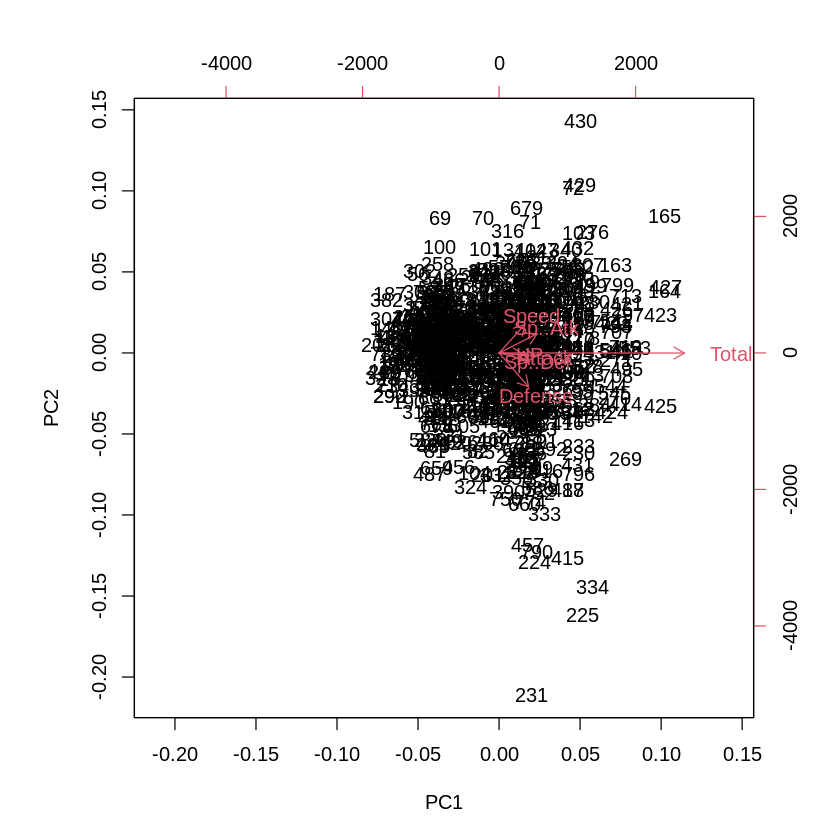

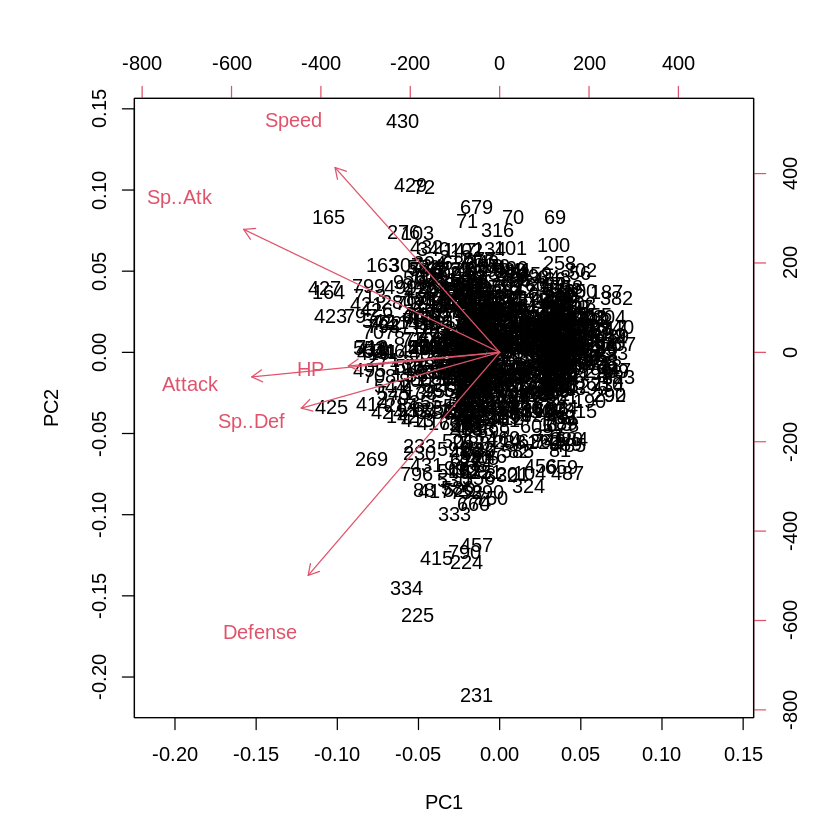

In [ ]:
pokemonData.pca<-prcomp(pokemonDataFiltrada)
pokemonData2.pca<-prcomp(pokemonDataFiltradaSinTotal)
biplot(pokemonData.pca)
biplot(pokemonData2.pca)

Me cuesta entender el biplot, pero creo que el primero indica que la variable Total carga con la mayor parte de la información como era esperado.

En el segundo biplot creo que las variables Ataque, Ataque Especial y Defensa son relevantes.

[1] "Analisis forward con suma total"
[1] "Analisis forward sin suma total"


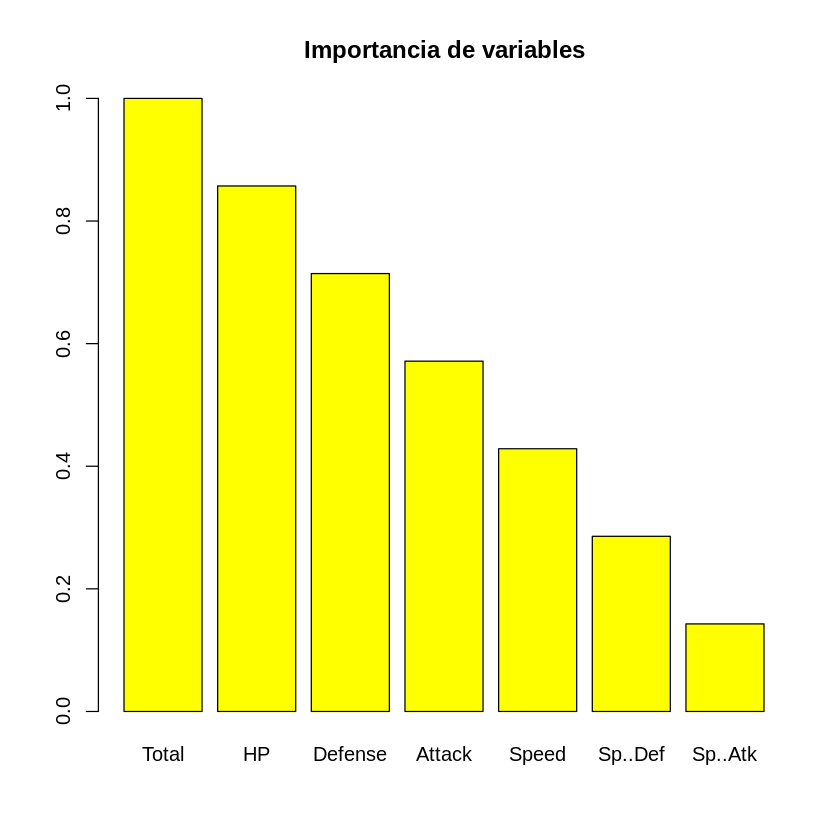

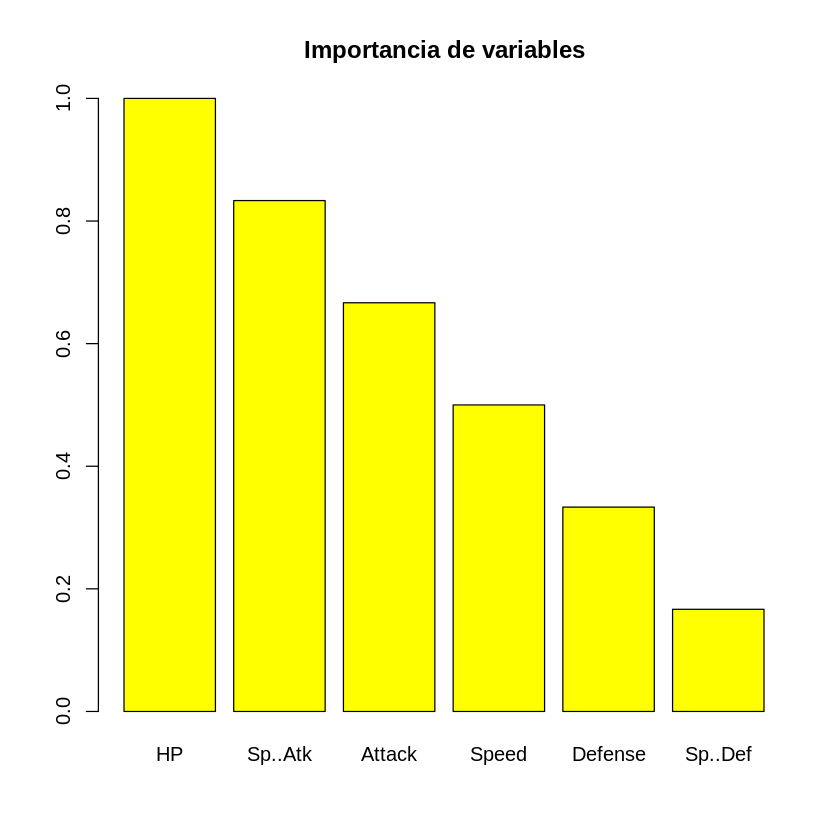

In [ ]:
invisible(capture.output(pokemonData.FORW.svm<-forward.ranking(pokemonDataFiltrada,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData.FORW.svm$importance, names=pokemonData.FORW.svm$ordered.names.list, col="yellow", main="Importancia de variables")

invisible(capture.output(pokemonData2.FORW.svm<-forward.ranking(pokemonDataFiltradaSinTotal,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData2.FORW.svm$importance, names=pokemonData2.FORW.svm$ordered.names.list, col="yellow", main="Importancia de variables")


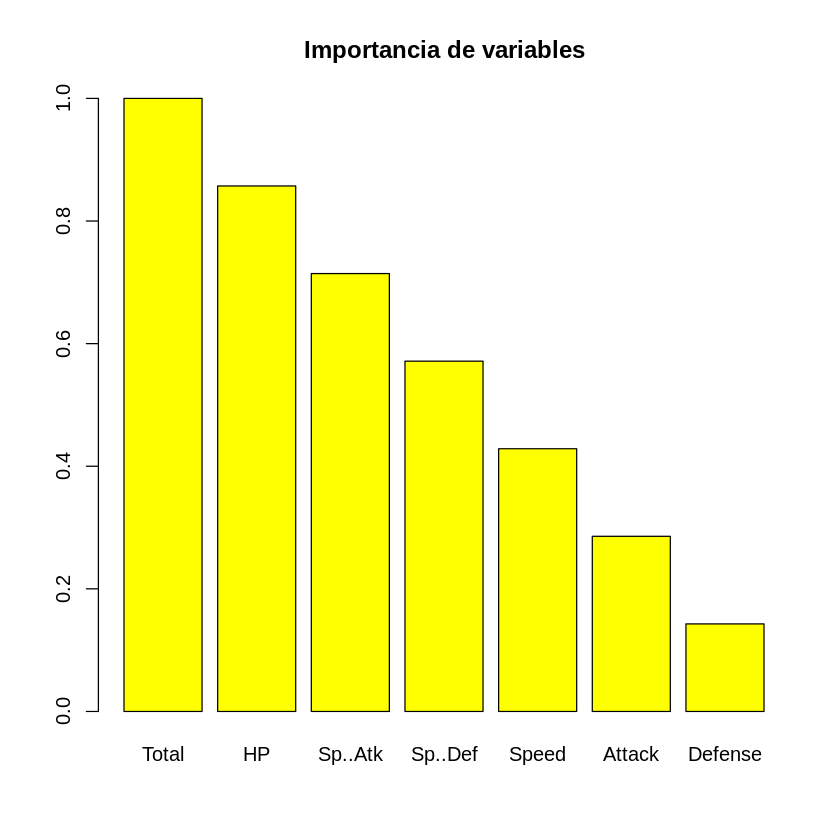

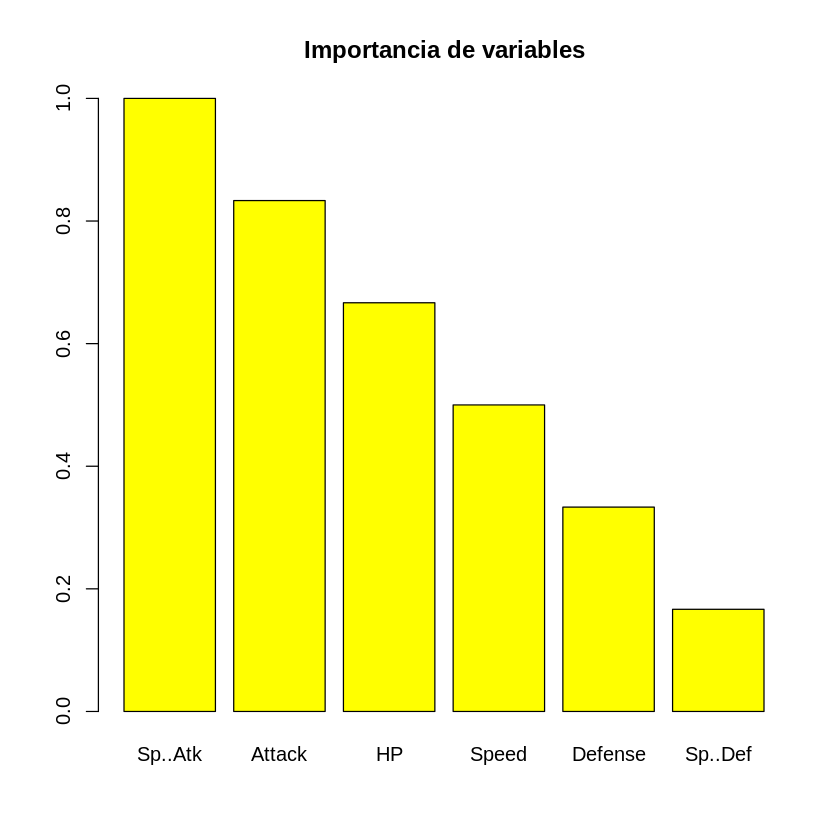

In [ ]:
invisible(capture.output(pokemonData.BACK.svm<-backward.ranking(pokemonDataFiltrada,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData.BACK.svm$importance, names=pokemonData.BACK.svm$ordered.names.list, col="yellow", main="Importancia de variables")

invisible(capture.output(pokemonData2.BACK.svm<-backward.ranking(pokemonDataFiltradaSinTotal,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData2.BACK.svm$importance, names=pokemonData2.BACK.svm$ordered.names.list, col="yellow", main="Importancia de variables")

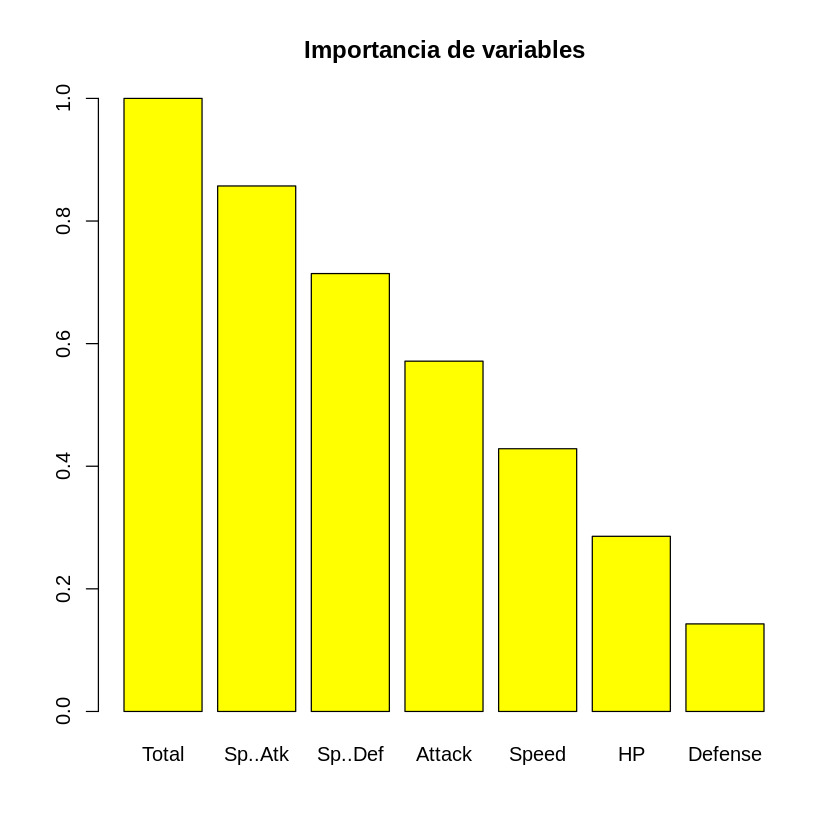

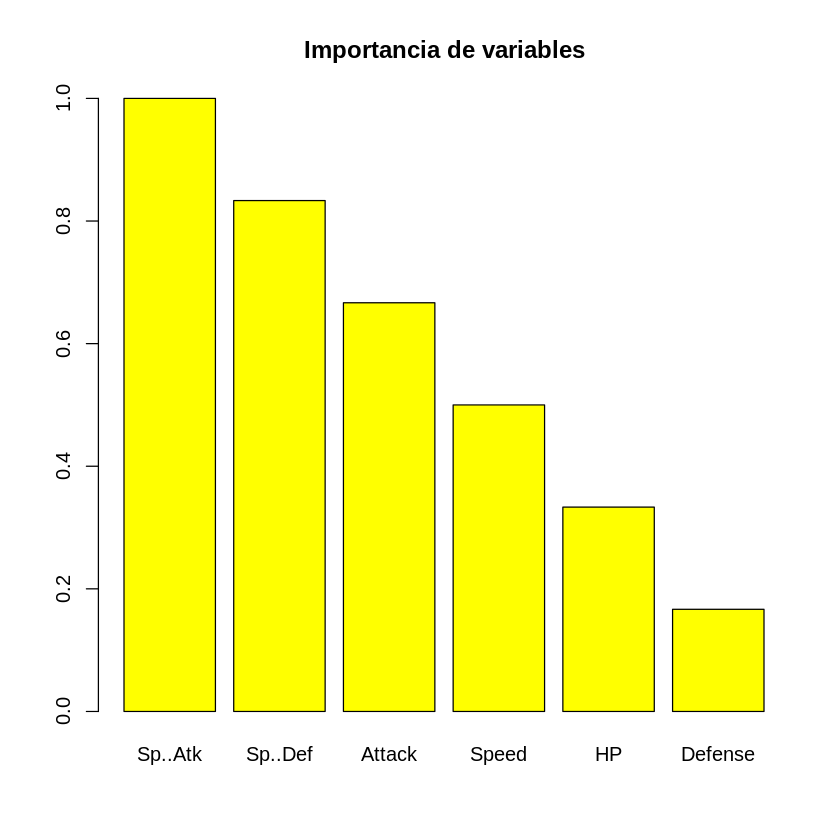

In [ ]:
pokemonData.noP <- no.parametrico(pokemonDataFiltrada,pokemonData[,13])
barplot(height=pokemonData.noP$importance, names=pokemonData.noP$ordered.names.list, col="yellow", main="Importancia de variables")

pokemonData2.noP <- no.parametrico(pokemonDataFiltradaSinTotal,pokemonData[,13])
barplot(height=pokemonData2.noP$importance, names=pokemonData2.noP$ordered.names.list, col="yellow", main="Importancia de variables")



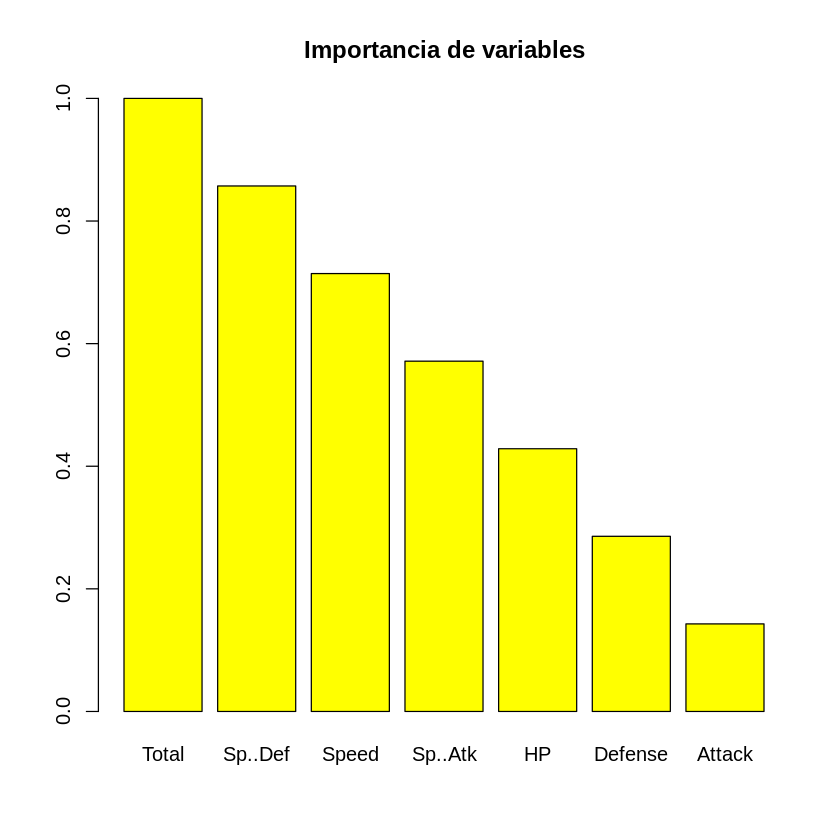

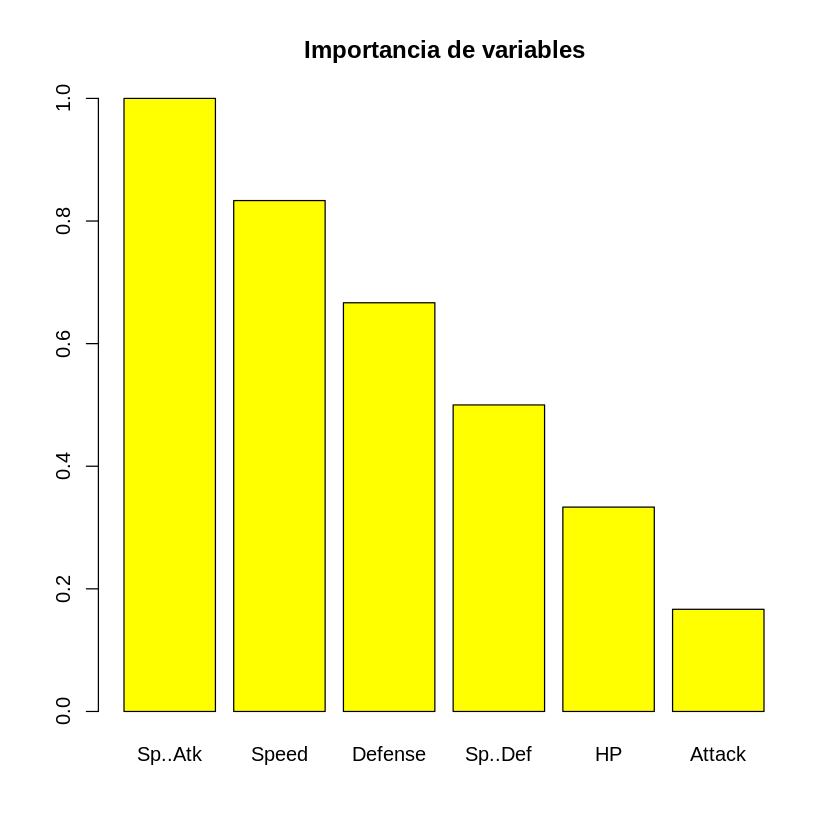

In [ ]:
invisible(capture.output(pokemonData.RFE.linsvm <- rfe(pokemonDataFiltrada,pokemonData[,13],method="imp.linsvm")))
barplot(height=pokemonData.RFE.linsvm$importance, names=pokemonData.RFE.linsvm$ordered.names.list, col="yellow", main="Importancia de variables")

invisible(capture.output(pokemonData2.RFE.linsvm <- rfe(pokemonDataFiltradaSinTotal,pokemonData[,13],method="imp.linsvm")))
barplot(height=pokemonData2.RFE.linsvm$importance, names=pokemonData2.RFE.linsvm$ordered.names.list, col="yellow", main="Importancia de variables")


Efectivamente, tanto en la PCA como en el resto de los métodos resulta que la suma total de las estadísticas es un muy buen indicador sobre el status de un pokémon como legendario.

Cuando se trata de hacer el análisis sin la variable del total, los resultados indican que las variables más relevantes suelen ser las de ataque especial, ataque y puntos de salud. Esto no me sorprende, ya que los pokemones legendarios suelen ser mayoritariamente ofensivos, pero con estadísticas defensivas superiores a la media (lo que podría explicar por qué rankean alto en los últimos análisis) 

Bonus track de un ataque de curiosidad: ¿La forma en la que están desparramados los pokemones en la pokedex me dirá algo interesante sobre su status de legendario?

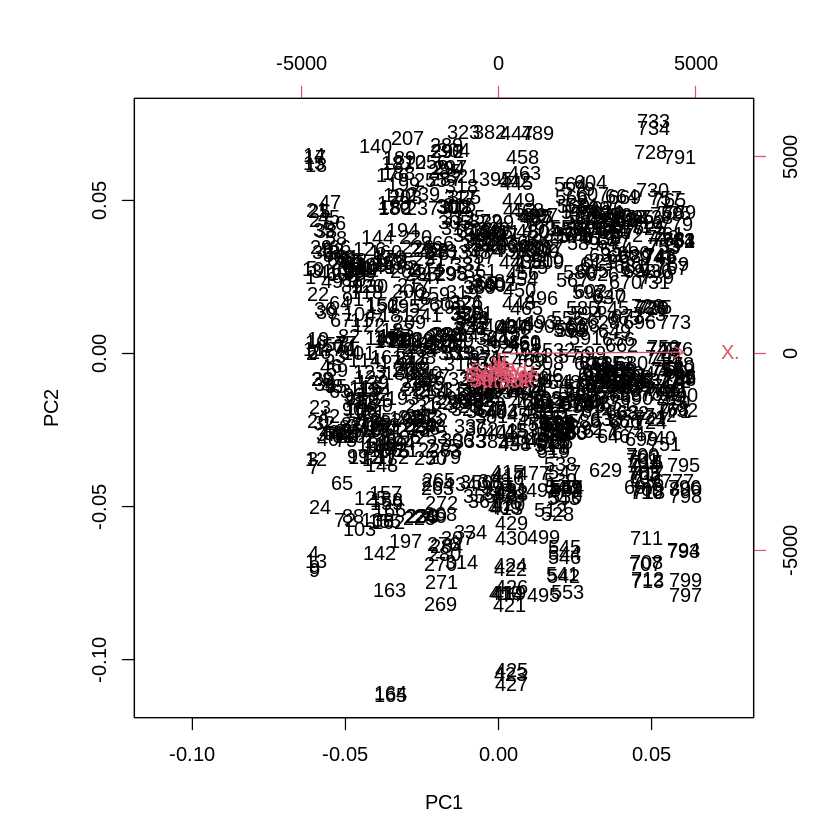

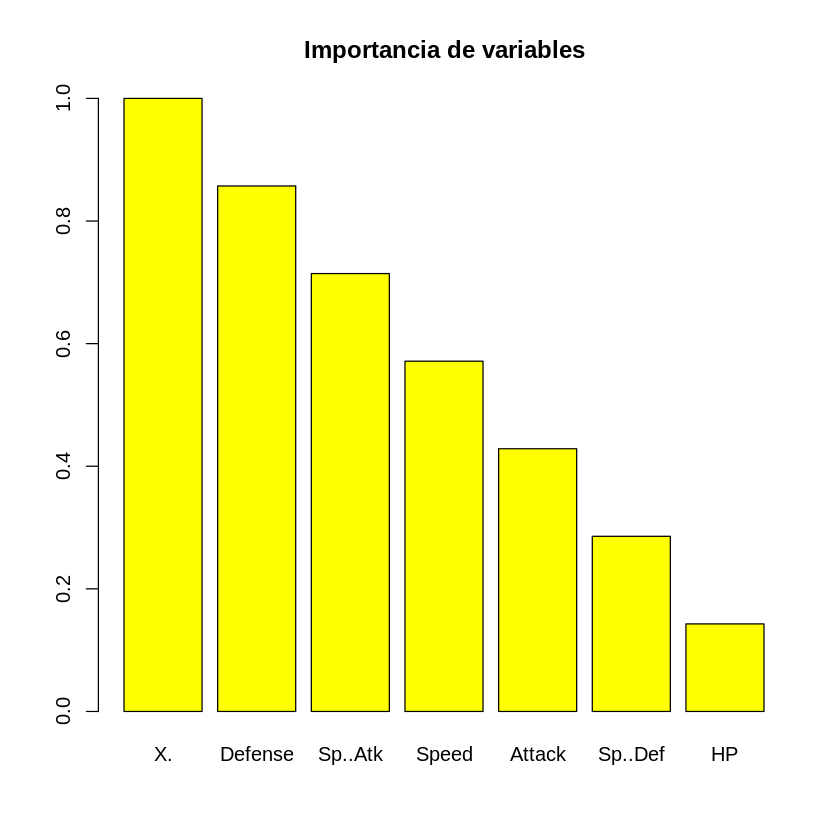

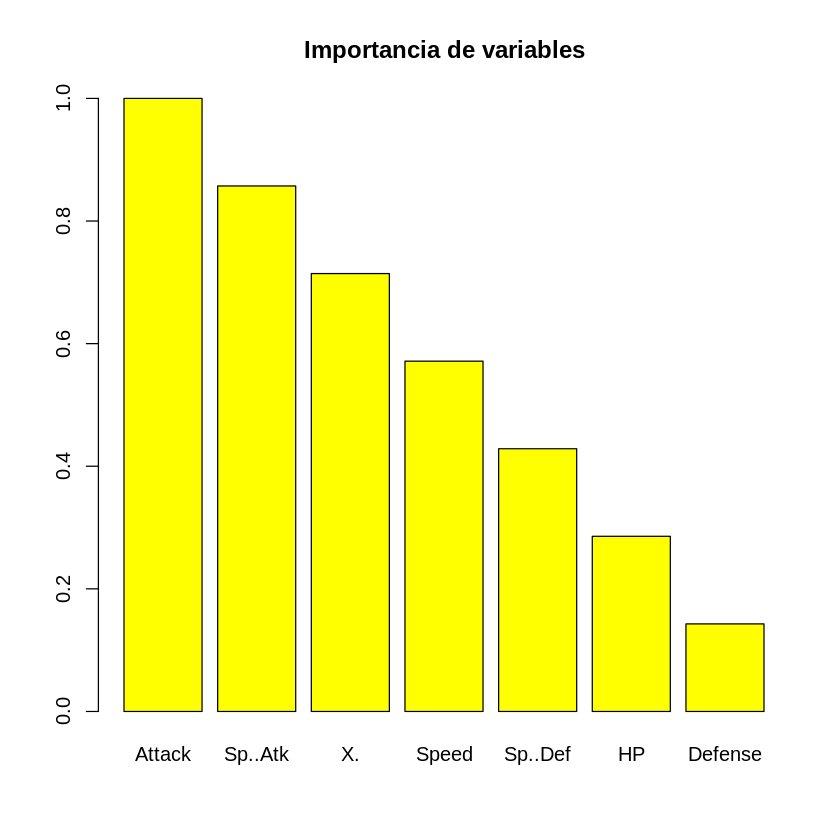

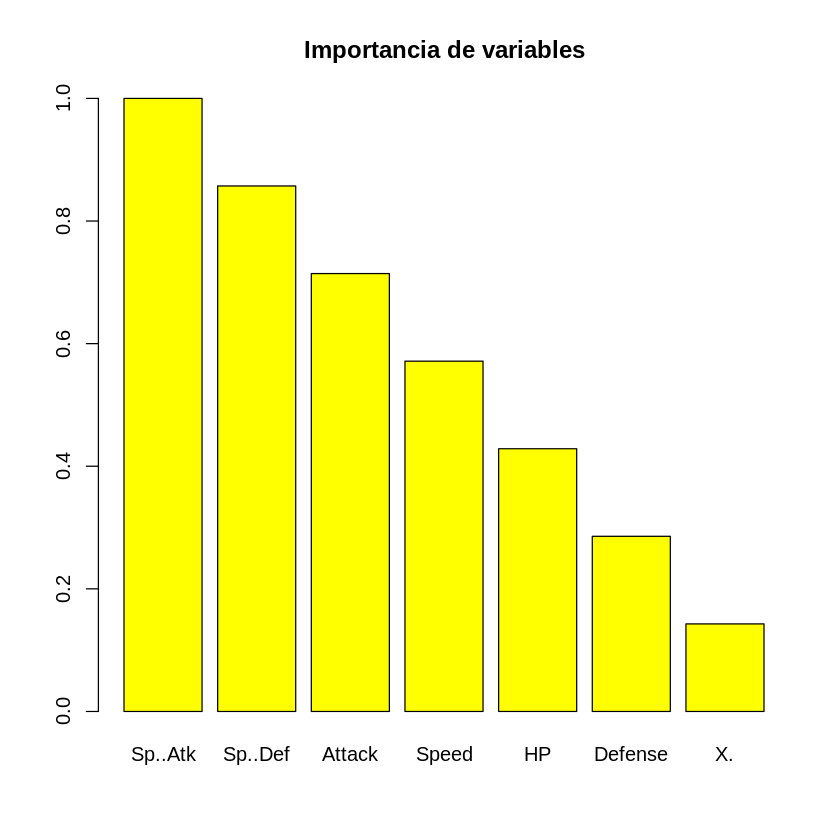

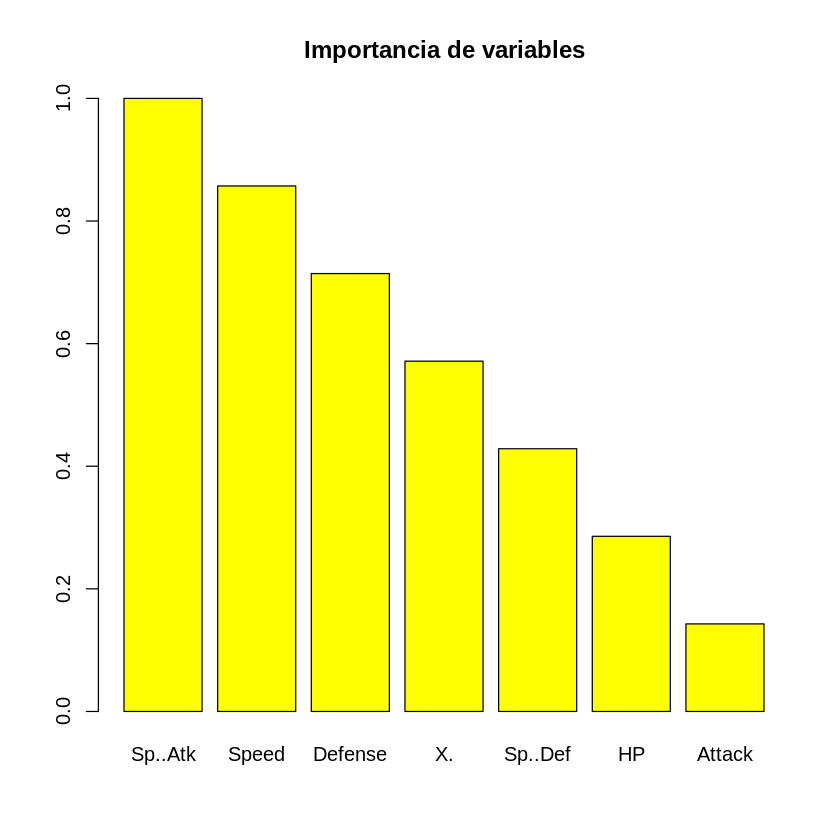

In [38]:
pokemonData3.pca<-prcomp(pokemonDataFiltradaSinTotalConId)
biplot(pokemonData3.pca)

invisible(capture.output(pokemonData3.FORW.svm<-forward.ranking(pokemonDataFiltradaSinTotalConId,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData3.FORW.svm$importance, names=pokemonData3.FORW.svm$ordered.names.list, col="yellow", main="Importancia de variables")

invisible(capture.output(pokemonData3.BACK.svm<-backward.ranking(pokemonDataFiltradaSinTotalConId,pokemonData[,13],method="svm.est")))
barplot(height=pokemonData3.BACK.svm$importance, names=pokemonData3.BACK.svm$ordered.names.list, col="yellow", main="Importancia de variables")

pokemonData3.noP <- no.parametrico(pokemonDataFiltradaSinTotalConId,pokemonData[,13])
barplot(height=pokemonData3.noP$importance, names=pokemonData3.noP$ordered.names.list, col="yellow", main="Importancia de variables")

invisible(capture.output(pokemonData3.RFE.linsvm <- rfe(pokemonDataFiltradaSinTotalConId,pokemonData[,13],method="imp.linsvm")))
barplot(height=pokemonData3.RFE.linsvm$importance, names=pokemonData3.RFE.linsvm$ordered.names.list, col="yellow", main="Importancia de variables")


Como los pokemones legendarios aparecen una vez por generacion, y generalmente al final, hay alrededor de 90 a 120 pokemones en el medio. Pense que quizás habría alguna especie de regularidad. 

Me parece una grata sorpresa que, al menos para la clasificación por forward, mi suposición sea correcta. Como forward las toma de a una, parecería ser que esa variable por sí sola es bastante relevante!  